**Решалась задача прогнозирования временного ряда.
В качестве данных для прогнозирования были взяты данные о среднемесячных уровнях заработной платы в России с января 1993 года по октябрь 2018 года. Данные взяты с ресурса:  http://sophist.hse.ru/exes/tables/WAG_M.htm.**

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Считаем данные и посмотрим на них

In [2]:
wages=pd.read_csv('WAG_C_M_1.csv', sep=';', parse_dates=['month'], dayfirst=True, index_col=['month'])

In [4]:
wages.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [5]:
wages['WAG_C_M']=wages.WAG_C_M.astype('float64')

Построим график временного ряда

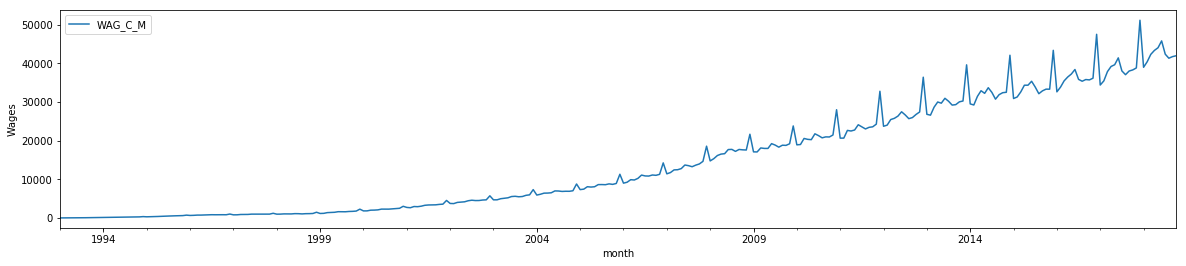

In [6]:
plt.figure(figsize(20,4))
wages.plot()
plt.ylabel('Wages')
pylab.show()

На графике явно выражен тренд на повышение и разная дисперсия, а также сезонность.
Сделаем проверку на стационарность и проверим критерий Дики-Фуллера.

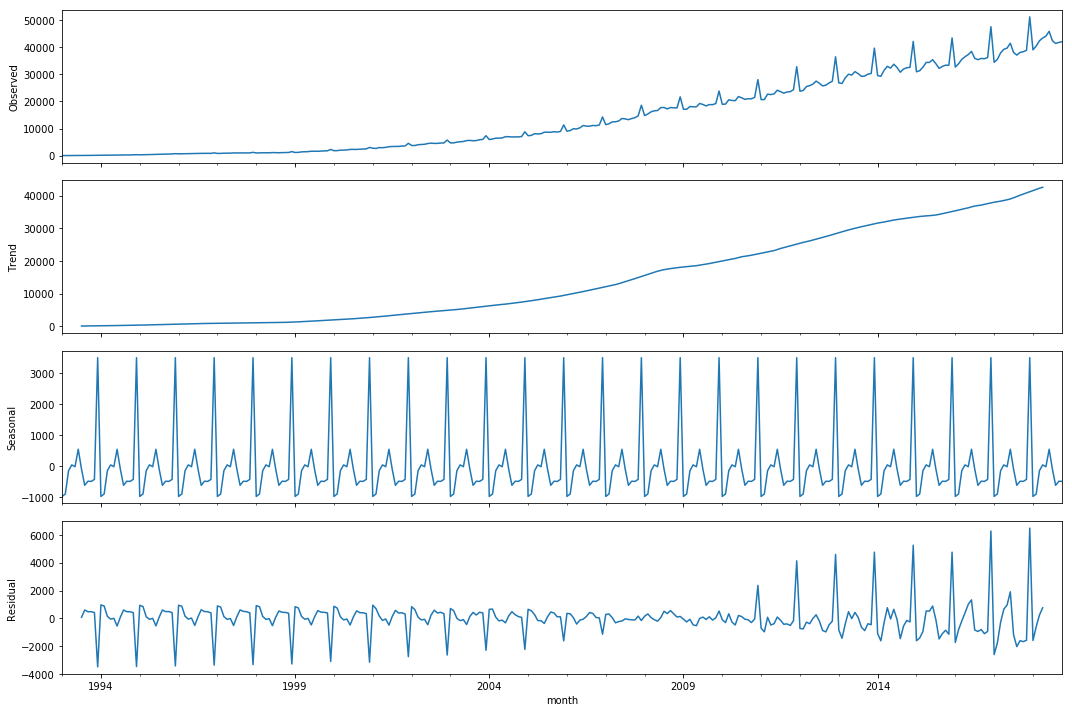

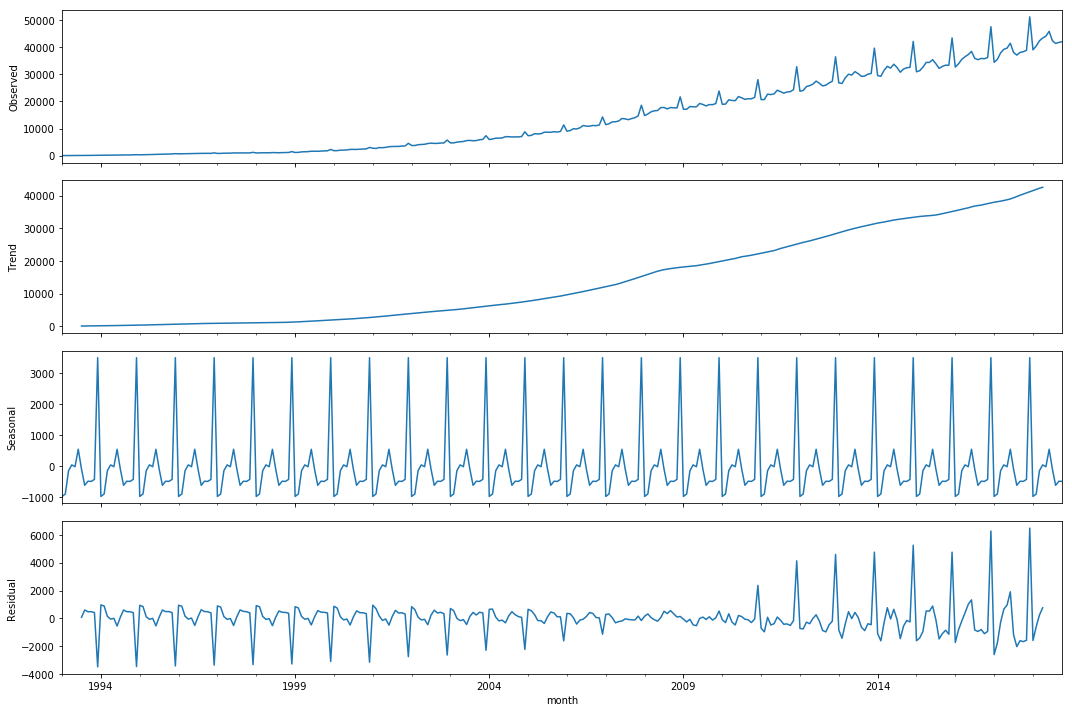

In [26]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.WAG_C_M).plot()

In [9]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.998596


Критерий, как и ожидалось, не отвергает гипотезу о нестационарности ряда.
На графиках также видно тренд и ярко выраженную сезонность.

Стабилизируем дисперсию с помощью критерия Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.281900
Критерий Дики-Фуллера: p=0.713060


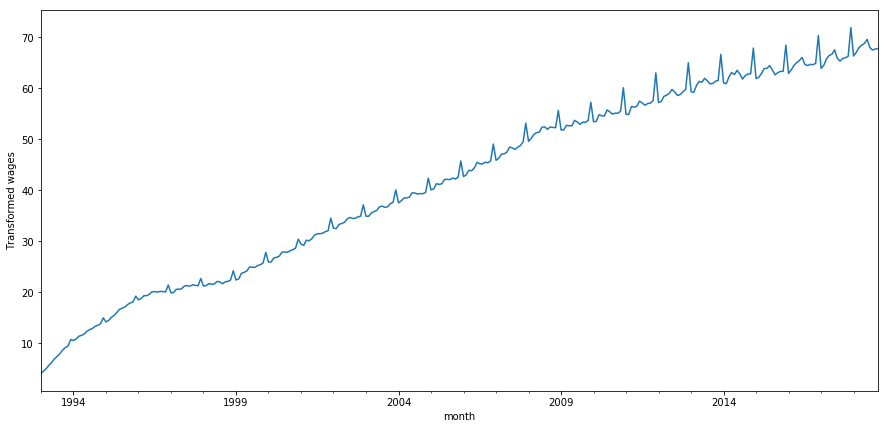

In [7]:
wages['wages_box'], lmbda = stats.boxcox(wages.WAG_C_M)
plt.figure(figsize(15,7))
wages.wages_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box)[1])

Критерий Дики-Фуллера до сих пор не отвергает нестационарность ряда, на графике также виден ярко выраженный тренд.
Сделаем дифференцирование ряда, начнем с сезонного.


Критерий Дики-Фуллера: p=0.122364


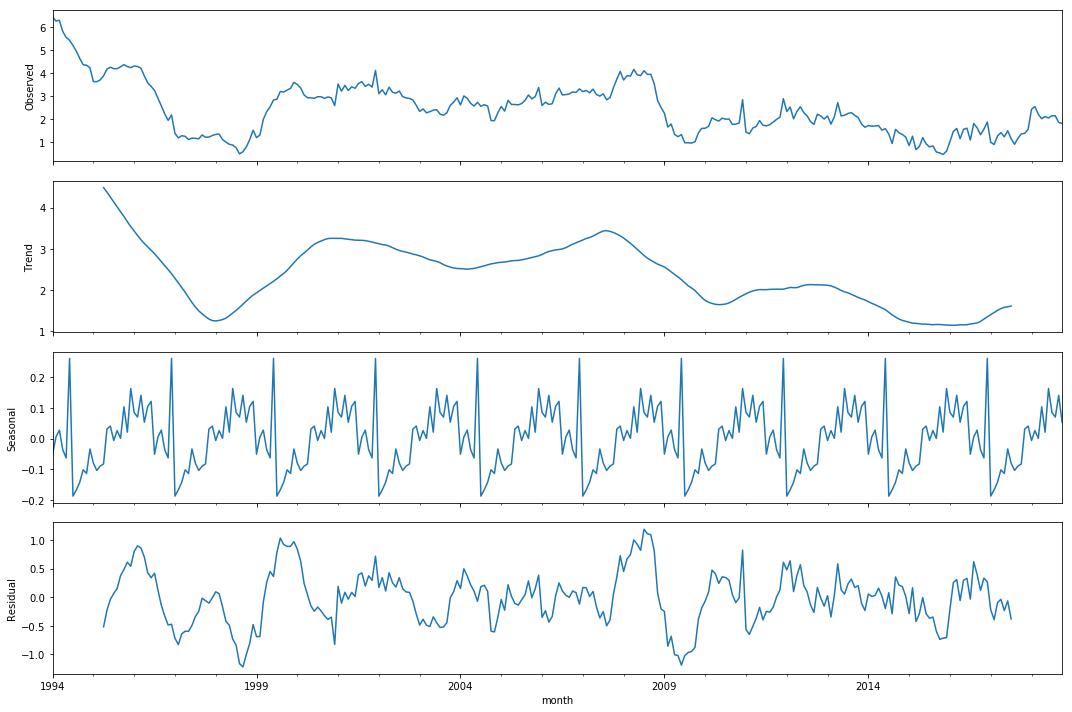

In [8]:
wages['wages_box_diff'] = wages.wages_box - wages.wages_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages_box_diff.dropna(), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box_diff.dropna())[1])

После дифференцирования небольшой тренд сохраняется, попробуем продифференцировать ряд еще раз.

Критерий Дики-Фуллера: p=0.000000


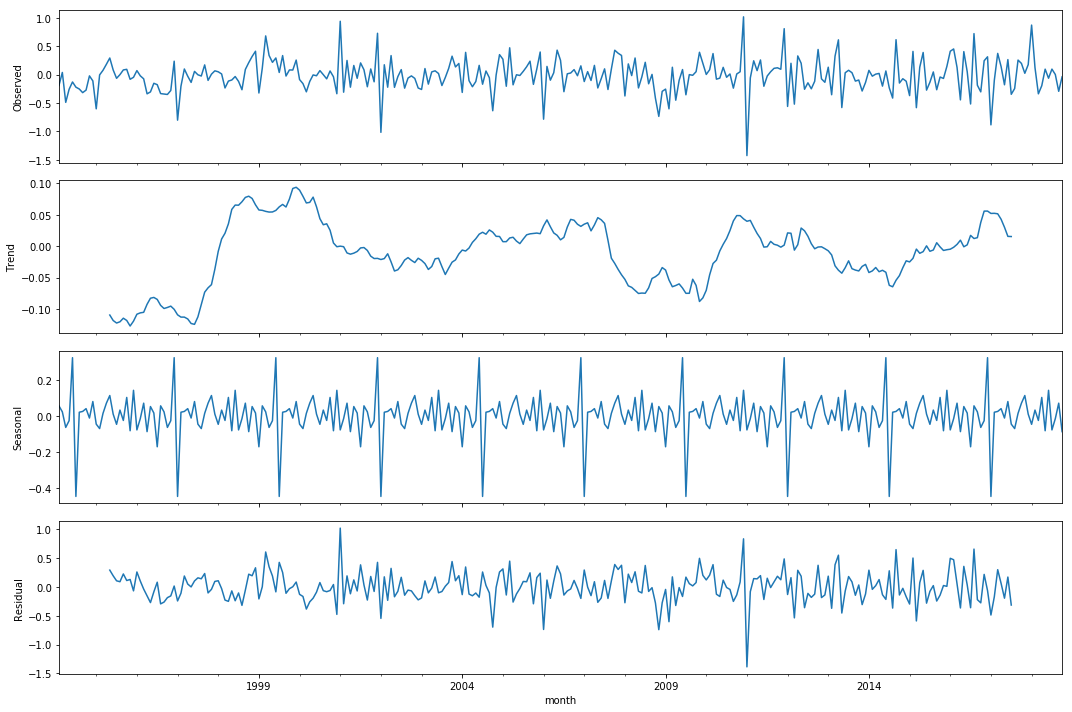

In [9]:
wages['wages_box_diff2'] = wages.wages_box_diff - wages.wages_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages_box_diff2.dropna(), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box_diff2.dropna())[1])

Гипотеза о нестационарности ряда уверенно отвергается, переходим к построению модели.
Посмотрим на графики автокорреляции ACF и частичной автокорреляции PACF для подбора параметров модели.

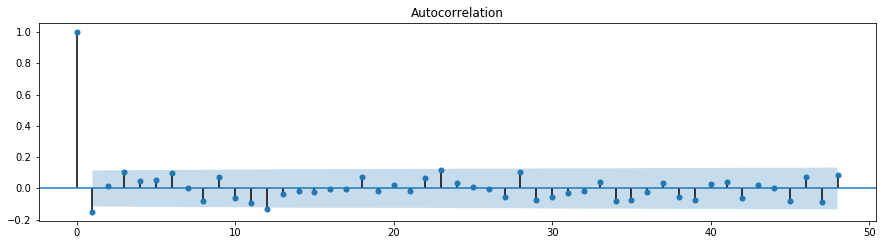

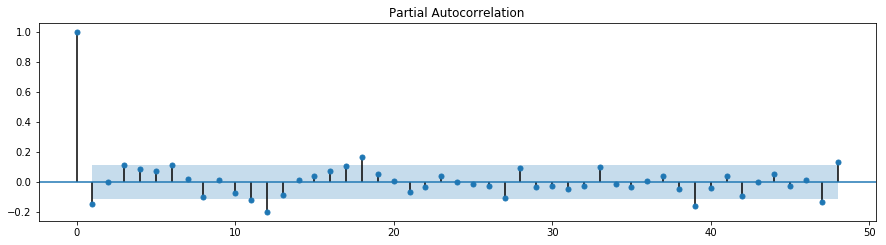

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wages.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wages.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Зададим начальные приближения параметров, исходя из построенных графиков

In [11]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

120

Проведем обучение и сравнение моделей с разными параметрами по информационному критерию Акаике

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(wages.wages_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 3, 1))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 1, 4, 1))
Wall time: 6min 4s


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
69   (3, 1, 4, 1)  90.606351
89   (4, 1, 4, 1)  91.879658
109  (5, 1, 4, 1)  92.156931
99   (5, 0, 4, 1)  93.171583
79   (4, 0, 4, 1)  95.228508


Лучшая модель:

In [15]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          wages_box   No. Observations:                  310
Model:             SARIMAX(3, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -35.303
Date:                            Fri, 23 Nov 2018   AIC                             90.606
Time:                                    21:07:05   BIC                            127.544
Sample:                                01-01-1993   HQIC                           105.394
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5095      0.182      2.807      0.005       0.154       0.865
ar.L2          0.0902      0.072   

Посмотрим на остатки модели

Критерий Стьюдента: p=0.971187
Критерий Дики-Фуллера: p=0.000000


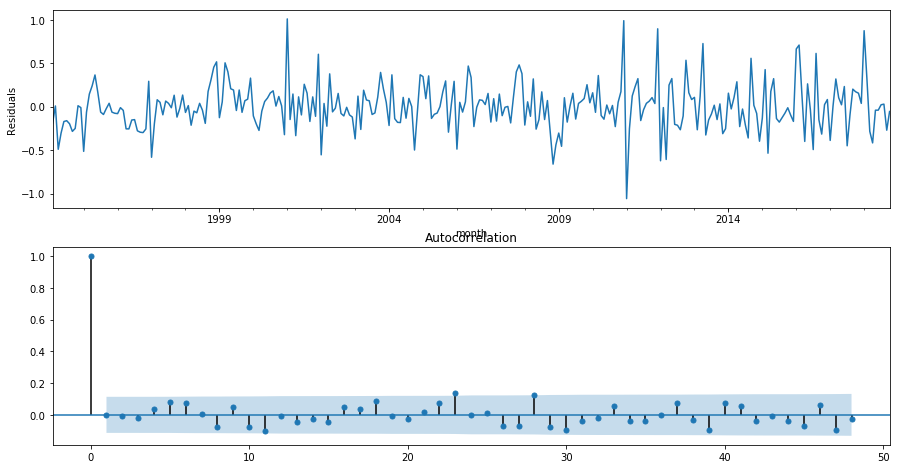

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

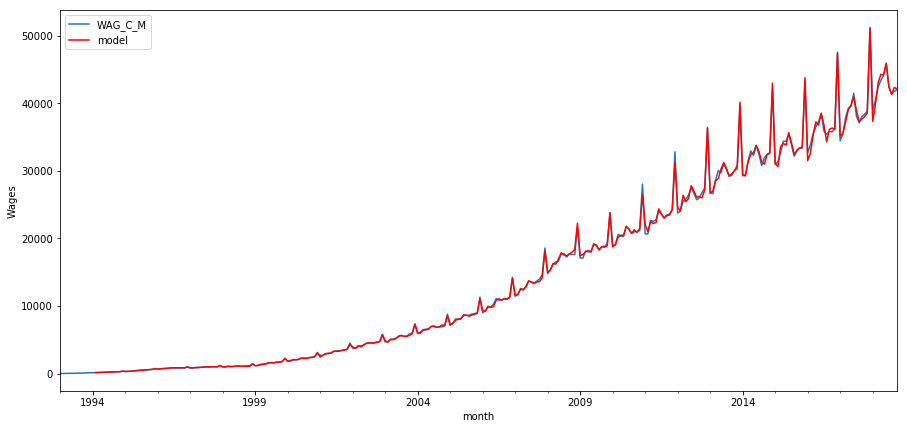

In [21]:
wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
wages.model[13:].plot(color='r')
plt.ylabel('Wages')
plt.legend()
pylab.show()

In [58]:
max(wages.index)

Timestamp('2016-08-01 00:00:00')

Построим прогноз по модели 

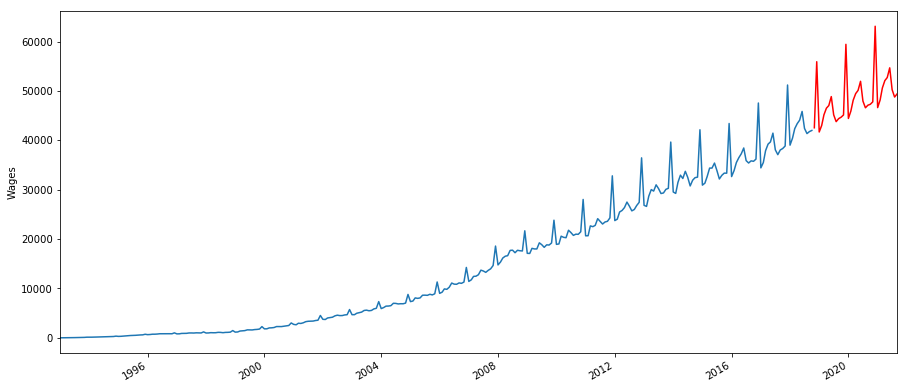

In [25]:
wages_all= wages[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2018-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wages_all.columns)
wages_all = pd.concat([wages_all, future])
wages_all['forecast'] = invboxcox(best_model.predict(start=310, end=346), lmbda)

plt.figure(figsize(15,7))
wages_all.WAG_C_M.plot()
wages_all.forecast.plot(color='r')
plt.ylabel('Wages')
pylab.show()

Прогноз выглядит неплохо, модель явно выделила основной тренд и сезонность.